In [1]:
import sys
print(sys.version)

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]


In [2]:
print(sys.executable)

/nbhome/ogrp/python/envs/py311_20240513/bin/python


In [4]:
import xarray as xr
data_dir = '/work/jet/sea_level_covariability/data/zarr/'
fname = 'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3_global_1958to2017_zos_monthly'
ds = xr.open_zarr(f'{data_dir+fname}',use_cftime=True)

In [5]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:    (yh: 1080, xh: 1440, time: 720)
Coordinates:
  * time       (time) object 6kB 1958-01-16 12:00:00 ... 2017-12-16 12:00:00
  * xh         (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yh         (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
Data variables:
    areacello  (yh, xh) float32 6MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    deptho     (yh, xh) float32 6MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    dt         (time) timedelta64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    geolat     (yh, xh) float32 6MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    geolon     (yh, xh) float32 6MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    wet        (yh, xh) float32 6MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    zos        (time, yh, xh) float32 4GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:    areacello: 19580101.ocean_static.nc
    external_variables:  areacello
    filename:            ocean_monthly.195801-196212.zos.nc
    grid_tile:           N/A
    grid_type:           regular
    title:               OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3

### Global map

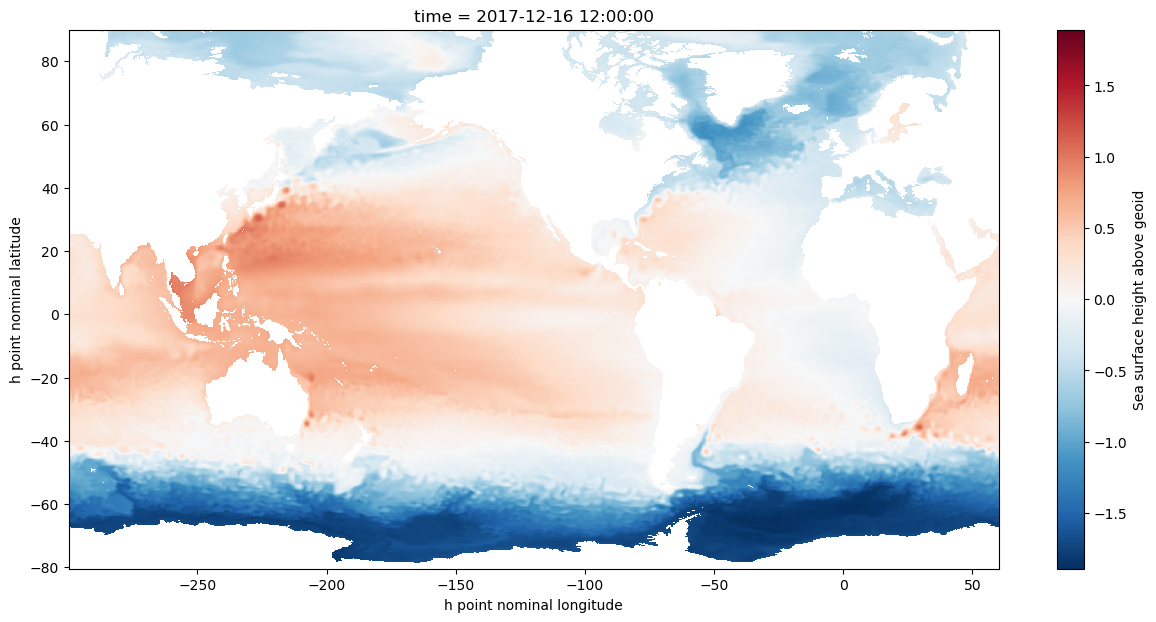

In [6]:
var = 'zos'
ds[var].isel(time=-1).plot(figsize=(15,7))

### Location

As case studies, we pick two grid cells: one in the Pacific near the Philippines (14.5$^\circ$N,  127$^\circ$E), and the other over the North Atlantic near the coast of New York City [NYC] (40$^\circ$N, 73$^\circ$W).

In [10]:
# Select coordinates for New York
lon = -72.8
lat = 40

In [11]:
print(ds.sel({'xh':lon,'yh':lat},method='nearest').geolon.values,
      ds.sel({'xh':lon,'yh':lat},method='nearest').geolat.values,'\n',
      ds.sel({'xh':lon,'yh':lat},method='nearest').xh.values,
      ds.sel({'xh':lon,'yh':lat},method='nearest').yh.values)

-73.125 40.029484 
 -72.69381401232572 40.02948388099686


In [13]:
from dask.diagnostics import ProgressBar

In [14]:
with ProgressBar():
    zos_NYC = ds.sel({'xh':lon,'yh':lat},method='nearest')[var].load()

[########################################] | 100% Completed | 5.47 sms


In [20]:
# Select coordinates near Philippines
lon = 127-360
lat = 14.5
print(ds.sel({'xh':lon,'yh':lat},method='nearest').geolon.values,
      ds.sel({'xh':lon,'yh':lat},method='nearest').geolat.values,'\n',
      ds.sel({'xh':lon,'yh':lat},method='nearest').xh.values,
      ds.sel({'xh':lon,'yh':lat},method='nearest').yh.values)

-232.625 14.589726 
 -233.0034912547871 14.589726512825457


In [21]:
with ProgressBar():
    zos_Pac = ds.sel({'xh':lon,'yh':lat},method='nearest')[var].load()

[########################################] | 100% Completed | 5.27 sms


In [22]:
import matplotlib.pyplot as plt

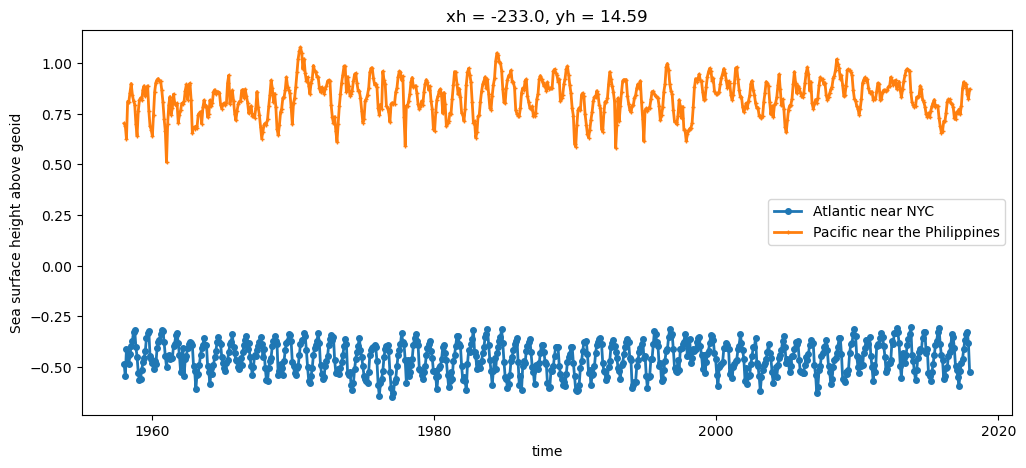

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
zos_NYC.plot(ax=ax,lw=2,marker='o', ms=4, label='Atlantic near NYC')
zos_Pac.plot(ax=ax,lw=2,marker='+', ms=3, label='Pacific near the Philippines')
ax.legend()
plt.show()

### Extracting tide gauge time series using `momlevel`

In [24]:
import momlevel

In [25]:
degd = 4 # 4 for 1/4 spatial resolution
max_dist = (111/degd)*1.5
print(max_dist,'km')

41.625 km


In [26]:
with ProgressBar():
    # Use momlevel internal subset
    ds_tide_gauge = momlevel.extract_tidegauge(ds[var],ds.geolon,ds.geolat,mask=ds.wet,
                                               threshold=max_dist, csv='global')

    # Use complete set of tide gauges 
    #ds_tide_gauge = momlevel.extract_tidegauge(ds[var],ds.geolon,ds.geolat,mask=ds.wet,threshold=max_dist,
    #                                           csv='/work/jet/psmsl/global_tide_gauges.csv')

[########################################] | 100% Completed | 203.26 ms
[########################################] | 100% Completed | 102.34 ms
[########################################] | 100% Completed | 304.19 ms


In [27]:
ds_tide_gauge

<xarray.Dataset> Size: 58kB
Dimensions:              (time: 720)
Coordinates:
  * time                 (time) object 6kB 1958-01-16 12:00:00 ... 2017-12-16...
Data variables: (12/18)
    WELLINGTON_HARBOUR   (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    ATLANTIC_CITY        (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    BALBOA               (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    KUSHIMOTO            (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    SAN_DIEGO            (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    BREST                (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    ...                   ...
    PAGO_BAY_GUAM        (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    SYDNEY_FORT_DENISON  (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    VENEZIA_ARSENALE     (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    CUXHAVEN             (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    ZANZIBAR             (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    PAPEETE              (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>

In [29]:
import pandas as pd

In [31]:
df_tide_gauge = pd.DataFrame()
for varname, da in ds_tide_gauge.data_vars.items():
    print(varname, da.attrs['mod_index'], da.attrs['real_coords'])
    df_loc = pd.DataFrame(da.attrs)[['Country', 'name', 'NOAA_name', 'PSMSLID', 'NOAAID', 'distance', 'mod_index']].iloc[0]
    df_loc['lat_model'] = da.attrs['model_coords'][0]
    if da.attrs['model_coords'][1] < -180:
        df_loc['lon_model'] = da.attrs['model_coords'][1] + 360
    else:
        df_loc['lon_model'] = da.attrs['model_coords'][1]
    df_loc[da.attrs['dims'][0]] = da.attrs['dim_vals'][0]
    df_loc[da.attrs['dims'][1]] = da.attrs['dim_vals'][1]
    df_loc['lat_real'] = da.attrs['real_coords'][0]
    df_loc['lon_real'] = da.attrs['real_coords'][1]

    df_tide_gauge = pd.concat([df_tide_gauge, df_loc.to_frame().T], ignore_index=True)

WELLINGTON_HARBOUR 324324 (-41.28434, 174.7798)
ATLANTIC_CITY 702311 (39.355, -74.418333)
BALBOA 577195 (8.966667, -79.566667)
KUSHIMOTO 677939 (33.475833, 135.773333)
SAN_DIEGO 675817 (32.713333, -117.173333)
BREST 737652 (48.38285, -4.494838)
CHARLESTON 674985 (32.781667, -79.925)
ALEXANDRIA 670349 (31.216667, 29.916667)
LAUTOKA 456550 (-17.604917, 177.43825)
NEW_YORK 706964 (40.7, -74.013333)
LUSI 672840 (32.133333, 121.616667)
BUENOS_AIRES 370696 (-34.6, -58.366667)
PAGO_BAY_GUAM 596463 (13.428333, 144.796667)
SYDNEY_FORT_DENISON 375257 (-33.85, 151.233333)
VENEZIA_ARSENALE 726871 (45.416667, 12.35)
CUXHAVEN 758716 (53.866667, 8.716667)
ZANZIBAR 509943 (-6.15, 39.183333)
PAPEETE 457770 (-17.533081, -149.572724)


In [35]:
df_tide_gauge

,Country,name,NOAA_name,PSMSLID,NOAAID,distance,mod_index,lat_model,lon_model,yh,xh,lat_real,lon_real
0,New Zealand,WELLINGTON_HARBOUR,NaN,221,NaN,15.219205,324324,-41.356289,174.625,-41.356287,-186.094871,-41.28434,174.7798
1,United States,ATLANTIC_CITY,Atlantic City,180,8534720.0,11.268995,702311,39.25948,-74.375,39.259479,-73.961253,39.355,-74.418333
2,Panama,BALBOA,NaN,163,NaN,21.078542,577195,8.963216,-79.375,8.963216,-79.034461,8.966667,-79.566667
3,Japan,KUSHIMOTO,NaN,134,NaN,11.013198,677939,33.424923,135.875,33.424921,-224.576887,33.475833,135.773333
4,United States,SAN_DIEGO,San Diego San Diego Bay,158,9410170.0,21.037449,675817,32.796715,-117.375,32.796715,-117.665319,32.713333,-117.173333
5,France,BREST,NaN,1,NaN,16.629121,737652,48.261093,-4.625,48.261093,-3.954127,48.38285,-4.494838
6,United States,CHARLESTON,NaN,234,NaN,22.244333,674985,32.586319,-79.875,32.586318,-79.542062,32.781667,-79.925
7,Egypt,ALEXANDRIA,NaN,503,NaN,11.495662,670349,31.313599,29.875,31.313598,30.277262,31.216667,29.916667
8,Fiji,LAUTOKA,NaN,1805,NaN,13.582776,456550,-17.711014,177.375,-17.711014,-183.354459,-17.604917,177.43825
9,United States,NEW_YORK,The Battery,12,8518750.0,34.204345,706964,40.411266,-73.875,40.411265,-73.454234,40.7,-74.013333


In [36]:
import cartopy

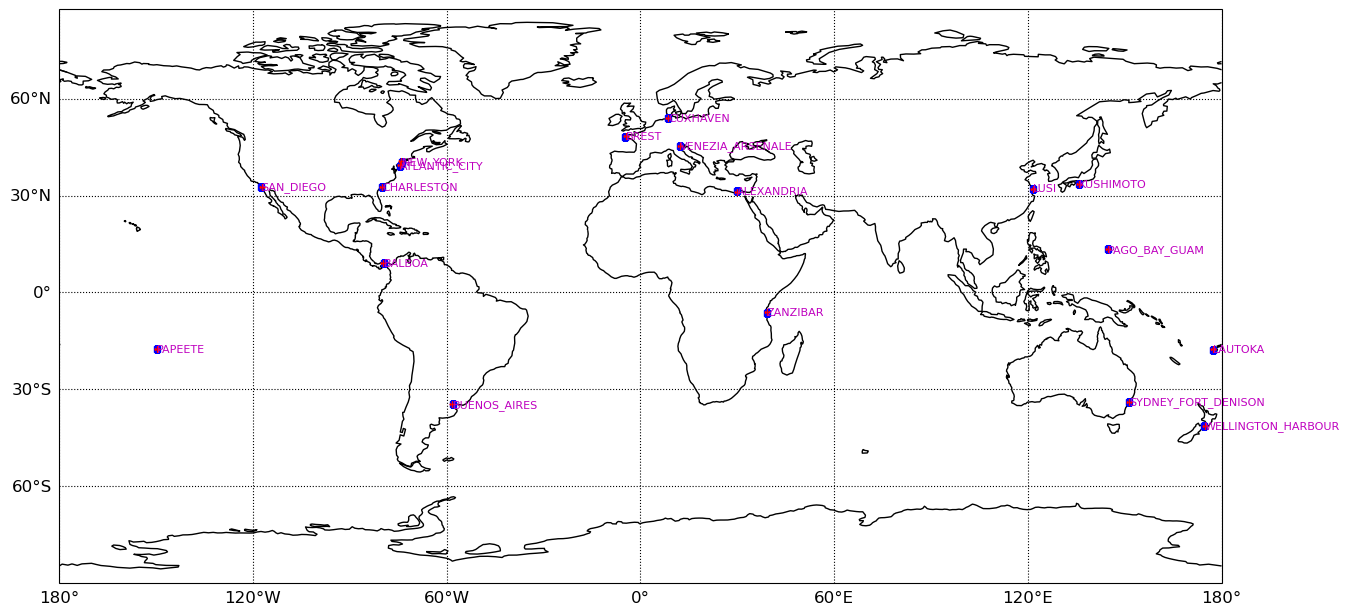

In [40]:
fig = plt.figure(figsize=[15, 20])
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'))

# Add sites
ax.plot(df_tide_gauge.lon_model.values, df_tide_gauge.lat_model.values, transform=cartopy.crs.Geodetic(),
        marker='s', color='b', markersize=5, linestyle='')
ax.plot(df_tide_gauge.lon_real.values, df_tide_gauge.lat_real.values, transform=cartopy.crs.Geodetic(),
        marker='+', color='r', markersize=5, linestyle='')

gl = ax.gridlines(linestyle=":",color='k', draw_labels=True,x_inline=False, y_inline=False,zorder=3)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}

# Add name for each tide gauge
for idx in range(0,len(df_tide_gauge)):
    ax.text(df_tide_gauge.iloc[idx].lon_model, df_tide_gauge.iloc[idx].lat_model, 
            df_tide_gauge.iloc[idx]['name'],
            color='m', fontsize=8, va='center', ha='left')
    
plt.show()

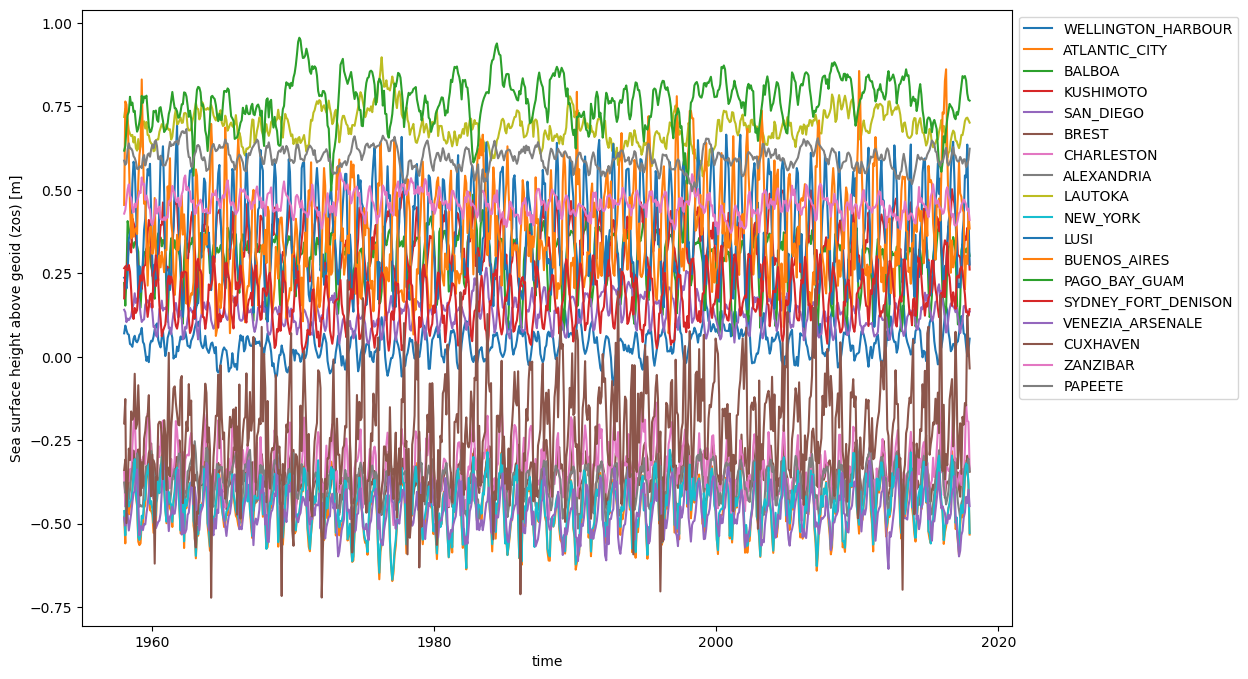

In [44]:
fig, ax = plt.subplots(figsize=(12,8))

for i, var in enumerate(list(ds_tide_gauge.keys())):
    var = ds_tide_gauge[var]
    var.plot(ax=ax,label=var.name)

ax.set_ylabel('Sea surface height above geoid (zos) [m]')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

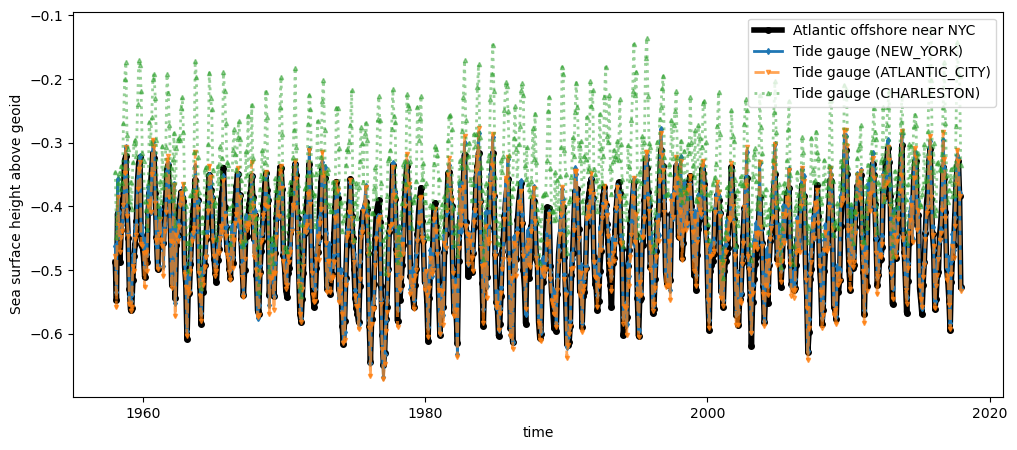

In [51]:
fig, ax = plt.subplots(figsize=(12,5))
zos_NYC.plot(ax=ax,lw=4,c= 'k', marker='o', ms=4, label='Atlantic offshore near NYC')
ds_tide_gauge.NEW_YORK.plot(ax=ax,lw=2,marker='d', ms=3, label='Tide gauge (NEW_YORK)')
ds_tide_gauge.ATLANTIC_CITY.plot(ax=ax,lw=2,ls ='--', alpha=0.7, marker='v', ms=3, label='Tide gauge (ATLANTIC_CITY)')
ds_tide_gauge.CHARLESTON.plot(ax=ax,lw=2,ls=':', alpha=0.5,marker='^', ms=3, label='Tide gauge (CHARLESTON)')
ax.legend()
plt.show()